# VGG-16 training for 21 Activities

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import brightside as bs

Defining common Keras functions

In [3]:
from __future__ import division
from keras.applications import vgg16
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import Callback
from easydict import EasyDict as edict
import numpy as np
from keras.constraints import maxnorm

import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.8):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

img_width, img_height = 224, 224

def define_model(img_width = 224, img_height = 224):
    base_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
        
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output        
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1', W_constraint=maxnorm(3))(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2', W_constraint=maxnorm(3))(x)
    x = Dropout(0.5)(x)
    x = Dense(21, activation='softmax', name='predictions')(x)
        
    return Model(input=base_model.input, output=x)

def define_finetuning_model(img_width = 224, img_height = 224):
    base_model = vgg16.VGG16(include_top=False, weights=None, input_shape=(img_width, img_height, 3))
        
    for layer in base_model.layers[:-4]:
        layer.trainable = False
        
    for layer in base_model.layers[-4:]:
        layer.trainable = True
        
    x = base_model.output        
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1', W_constraint=maxnorm(3))(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2', W_constraint=maxnorm(3))(x)
    x = Dropout(0.5)(x)
    x = Dense(21, activation='softmax', name='predictions')(x)
    
    
    
    model = Model(input=base_model.input, output=x)
    model.load_weights('weights.VGG-16.FC.09.hdf5')
    return model

class HistoryLog(Callback):
    def on_train_begin(self,logs={}):
        self.training = edict({'loss': []})
        self.epoch = edict({'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []})

    def on_epoch_end(self, epoch, logs={}):        
        self.epoch.acc.append(logs.get('acc'))
        self.epoch.loss.append(logs.get('loss'))
        self.epoch.val_acc.append(logs.get('val_acc'))
        self.epoch.val_loss.append(logs.get('val_loss'))
        
    def on_batch_end(self, batch, logs={}):
        self.training.loss.append(logs.get('loss'))
        
    def log_training_loss(self, filepath):
        training_loss = np.array(self.training.loss)
        np.savetxt(filepath, training_loss, delimiter=",")
        
    def log_epoch(self, filepath):
        epoch = np.asarray([self.epoch.loss, self.epoch.val_loss, self.epoch.acc, self.epoch.val_acc])
        np.savetxt(filepath, epoch.T, delimiter=",")

Using TensorFlow backend.


Printing VGG-16 adjusted architecture

In [6]:
model = define_model()
model.summary()
K.clear_session()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [4]:
model = define_finetuning_model()
model.summary()
K.clear_session()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Training

In [4]:
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 

seed = 42
np.random.seed(seed)

sgd = SGD(lr=0.0001, decay=0.000005, momentum=0.9, nesterov=True)
model = define_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/training', 
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=1)

validation_generator = val_datagen.flow_from_directory(
        'data/validation',
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=1)

# checkpoint
weights_filepath="weights.VGG-16.{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_acc', verbose=1, save_best_only=False)
history = HistoryLog()

# fine-tune the model
model.fit_generator(
        train_generator,
        samples_per_epoch=36095,#36095,#15,
        nb_epoch=10,
        callbacks=[checkpoint, history],
        validation_data=validation_generator,
        nb_val_samples=6225)#6225)#20)

loss_filepath = "loss.log"
history.log_training_loss(loss_filepath)

epoch_filepath = "epoch.log"
history.log_epoch(epoch_filepath)

K.clear_session()

Found 36095 images belonging to 21 classes.
Found 6225 images belonging to 21 classes.
Epoch 1/10
36095/36095 [==============================] - 8770s - loss: 2.3400 - acc: 0.3260 - val_loss: 1.8992 - val_acc: 0.4223
Epoch 2/10
36095/36095 [==============================] - 8725s - loss: 1.9744 - acc: 0.4143 - val_loss: 1.6615 - val_acc: 0.5155
Epoch 3/10
36095/36095 [==============================] - 8614s - loss: 1.8227 - acc: 0.4557 - val_loss: 1.5523 - val_acc: 0.5616
Epoch 4/10
36095/36095 [==============================] - 8557s - loss: 1.7106 - acc: 0.4845 - val_loss: 1.5547 - val_acc: 0.5569
Epoch 5/10
36095/36095 [==============================] - 8551s - loss: 1.6430 - acc: 0.5078 - val_loss: 1.4938 - val_acc: 0.5595
Epoch 6/10
36095/36095 [==============================] - 8568s - loss: 1.5841 - acc: 0.5207 - val_loss: 1.4645 - val_acc: 0.5658
Epoch 7/10
36095/36095 [==============================] - 8607s - loss: 1.5444 - acc: 0.5320 - val_loss: 1.4062 - val_acc: 0.5794
Epo

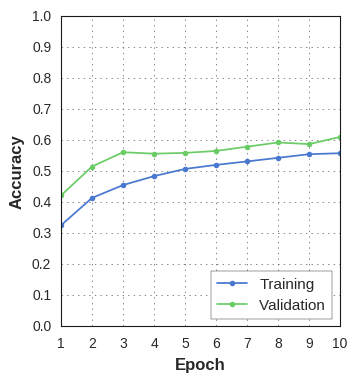

In [5]:
epoch_log = np.loadtxt('epoch.log', delimiter=',')
loss, val_loss, acc, val_acc = np.split(epoch_log, 4, axis=1)

epochs=np.arange(1, len(acc)+1)
fig, ax = bs.plot_accuracy([acc, val_acc],['Training','Validation'], epochs=epochs,figsize=(6,4))

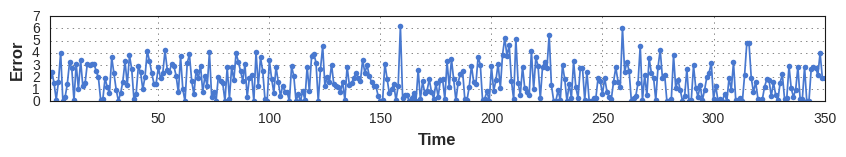

In [39]:
loss = np.loadtxt('loss.FC.log')
fig, ax = bs.plot_loss(loss[np.arange(0,350000,1000)],figsize=(10,5))
axes = plt.gca()
axes.set_aspect(len(np.arange(0,350000,1000))/64)

In [ ]:
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 

seed = 42
np.random.seed(seed)

sgd = SGD(lr=0.001, decay=0.000005, momentum=0.9, nesterov=True)
model = define_finetuning_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/training', 
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=1)

validation_generator = val_datagen.flow_from_directory(
        'data/validation',
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=1)

# checkpoint
weights_filepath="weights.VGG-16.{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_acc', verbose=1, save_best_only=False)
history = HistoryLog()

# fine-tune the model
model.fit_generator(
        train_generator,
        samples_per_epoch=36095,#36095,#15,
        nb_epoch=10,
        callbacks=[checkpoint, history],
        validation_data=validation_generator,
        nb_val_samples=6225)#6225)#20)

loss_filepath = "loss.log"
history.log_training_loss(loss_filepath)

epoch_filepath = "epoch.log"
history.log_epoch(epoch_filepath)

K.clear_session()

Found 36095 images belonging to 21 classes.
Found 6225 images belonging to 21 classes.
Epoch 1/10
   77/36095 [..............................] - ETA: 10490s - loss: 9.2749 - acc: 0.2208

## Testing

In [21]:
from __future__ import division
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
import collections

def files_from(directory):
    for file_ in os.listdir(directory):
        filepath = os.path.join(directory, file_)
        if not os.path.isfile(filepath):
            continue
        yield filepath
        
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test/',
                target_size=(img_height, img_width),
                batch_size=1)


num_test_classes = len(test_generator.classes)

accuracies = list()

file_prefix="weights.VGG-16."
weights_filepaths = [f for f in files_from('.') if f[2:].startswith(file_prefix)]

for weights_filepath in weights_filepaths:
    epoch = weights_filepath.split('.')[-2]
    model = define_model()
    model.compile(loss='categorical_crossentropy',optimizer=None, metrics=['accuracy'])
    model.load_weights(weights_filepath)
    loss, acc = model.evaluate_generator(test_generator, num_test_classes)
    print 'Accuracy for epoch {}: {}'.format(epoch, acc)
    accuracies.append(acc)
    K.clear_session()     

Found 2582 images belonging to 21 classes.
Accuracy for epoch 00: 0.100309837335
Accuracy for epoch 03: 0.133617350891


In [22]:
K.clear_session()